# OsuLearn
## An attempt at creating a Neural Network that learns how to play osu!std like a human from replays

##### (Plz don't judge me too much I'm new to machine learning and I can't english)

In [1]:
import os
import re
import math
import glob
from importlib import reload

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import osu.rulesets.beatmap
import osu.rulesets.replay
import osu.rulesets.hitobjects as hitobjects
import osulearn.dataset

## osu!

> osu! is a free and open-source rhythm game developed and published by Australian-based company PPY Developments PTY, created by Dean Herbert (also known as peppy). Originally released for Microsoft Windows on September 16, 2007, the game has also been ported to macOS (this version might be unstable), and Windows Phone. Its gameplay is based on titles including Osu! Tatakae! Ouendan, Elite Beat Agents, Taiko no Tatsujin, Beatmania IIDX, O2Jam, and DJMax. 
>
> -- <cite>[Wikipedia](https://en.wikipedia.org/wiki/Osu!)</cite>

In [1]:
OSU_FOLDER = "%LocalAppData%/osu!"

## Objective

This project aims to create a Neural Network that is capable of learning how to play osu! as humanly as possible.


## Approach

To accomplish that, I'll be applying [supervised learning](https://en.wikipedia.org/wiki/Supervised_learning) by feeding a [Recurrent Neural Network](https://en.wikipedia.org/wiki/Recurrent_neural_network) with beatmap data as input, training it to reproduce replay data from my recorded plays. These will be read from my Replay and Songs directories at my osu! installation respectively.

In the future, it would be interesting to try and implement a Conditional [Generative Adversarial Network (GAN)](https://en.wikipedia.org/wiki/Generative_adversarial_network) model that receives beatmap data as input and outputs replay data, as this would allow to generate a variety of replays for the same map, which the current model can't do.

## The learning data

First, all the `.osr` files in the osu! directory are enumerated and put into a table mapping replay file names to the `.osu` file for the replay's beatmap.

This is quite expensive to do every time, so a cache file is stored in the `.data/` folder in OsuLearn root dir to reduce overhead. Also, the code is huge and not very enlightening (it's basically a bunch of `glob`s), so it's been moved to `osulearn/dataset.py` to avoid cluttering this notebook.

In [3]:
data_files = osulearn.dataset.all_files(OSU_FOLDER, verbose=True)
#data_files.applymap(os.path.basename)

[=======================================>] C:/Users/guigb/AppData/Local/osu... 



After enumerating the required files, they are mapped into `osu.ruleset` objects so we can extract useful information from them. This is done separately from file enumeration mainly because I like to see the Replay/Beatmap filename table, and it's nice to have a progress bar for each step.

Please notice DT and HR are not supported because they change timing and object position respectively, and I'm too lazy atm to take that into account.

In [4]:
dataset = osulearn.dataset.load(data_files, verbose=2)

[>.......................................] BzMasked - Aiobahn & Yunomi - Ma... 
	Failed: Not a osu!std replay
[=========>..............................] BzMasked - Erio wo Kamatte-chan ... 
	Failed: DT and HR are not supported yet
[==========>.............................] BzMasked - Galileo Galilei - Ara... 
	Failed: DT and HR are not supported yet
[=======================================>] BzMasked - Zekk - Calling [Iride... 

With our `osu.ruleset` objects DataFrame in hands, we can now get the data we are really interested in. This step is very time consuming, mainly because it has to calculate the list of visible objects for each frame on every beatmap. I've applyed some optimizations on that but it's still quite time-consuming.

The generated input and target data are stored on files in the `.data/` folder in OsuLearn root dir, and are not updated if the generated files are present. If you have saved a new replay, please delete `.data/input_data.dat` and `.data/target_data.dat`.

In [5]:
try:
    input_data = pd.read_pickle('.data/input_data.dat')
except:
    input_data = osulearn.dataset.input_data(dataset, verbose=True)
    input_data.to_pickle('.data/input_data.dat')

X = np.reshape(input_data.values, (-1, osulearn.dataset.BATCH_LENGTH, len(osulearn.dataset.INPUT_FEATURES)))

X.shape

(512, 2048, 5)

In [6]:
try:
    target_data = pd.read_pickle('.data/target_data.dat')
except:
    target_data = osulearn.dataset.target_data(dataset, verbose=True)
    target_data.to_pickle('.data/target_data.dat')

y = np.reshape(target_data.values, (-1, osulearn.dataset.BATCH_LENGTH, len(osulearn.dataset.OUTPUT_FEATURES)))

y.shape

(512, 2048, 2)

## Neural Network model

The training data is ready, so the next step is to create our model. As I've said at the beginning, I'm new to Machine Learning, so this model is built mostly on top of educated guesses.

I think it's reasonable to use a LSTM because replays are time sequences and it's past states are relevant to calculate the next one. Maybe I should use some kind of convolutional layer, but I'm not sure where and how and when I tried to it just made the cursor shake like hell, so maybe not.

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, CuDNNLSTM as LSTM, Input, GaussianNoise

map_input = Input(shape=X.shape[1:], name='map_info')

lstm = LSTM(64, return_sequences=True)(map_input)
pos = Dense(64, activation='linear')(lstm)
pos = GaussianNoise(0.2)(pos)
pos = Dense(16, activation='linear')(pos)
pos = Dense(y.shape[2], activation='linear', name='position')(pos)

model = Model(inputs=map_input, outputs=pos)
model.compile(optimizer=tf.train.AdamOptimizer(), loss='mae')
model.summary()

try:
    model.load_weights(".data/model.hdf5")
except Exception as e:
    print()
    print("Failed to load weights: ", e)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
map_info (InputLayer)        (None, 2048, 5)           0         
_________________________________________________________________
cu_dnnlstm (CuDNNLSTM)       (None, 2048, 64)          18176     
_________________________________________________________________
dense (Dense)                (None, 2048, 64)          4160      
_________________________________________________________________
gaussian_noise (GaussianNois (None, 2048, 64)          0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048, 16)          1040      
_________________________________________________________________
position (Dense)             (None, 2048, 2)           34        
Total params: 23,410
Trainable params: 23,410
Non-trainable params: 0
_________________________________________________________________

Faile

## Training

The training is done by splitting the dataset randomly into training and testing groups and exposing the Neural Network only to the training group. This process is then repeated until the loss is acceptable.

From my experience, a good point to stop is at about 0.0600. The number of epochs until this happens may vary depending on the size of the dataset, so feel free to tweak the `ITERATIONS` and `EPOCHS` values as needed to approach this result (or run the next cell until it's done, whatever).

In [8]:
from random import randint
from sklearn.model_selection import train_test_split

ITERATIONS = 24
EPOCHS = 8

try:
    loss
except NameError:
    loss = []
    
for i in range(ITERATIONS):
    print("Iteration #%d" % (i + 1))
    print("_" * 80)
    print()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randint(0, 100))
    h = model.fit(X_train, y_train, batch_size=1024, epochs=EPOCHS, verbose=1)
    loss += h.history['loss']
    print()

model.save_weights(".data/model.hdf5")

Iteration #1
________________________________________________________________________________

Epoch 1/8
358/358 [==============================] - 9s 26ms/step - loss: 0.3178
Epoch 2/8
358/358 [==============================] - 0s 1ms/step - loss: 0.2997
Epoch 3/8
358/358 [==============================] - 0s 1ms/step - loss: 0.2999
Epoch 4/8
358/358 [==============================] - 0s 1ms/step - loss: 0.2921
Epoch 5/8
358/358 [==============================] - 0s 1ms/step - loss: 0.2829
Epoch 6/8
358/358 [==============================] - 0s 1ms/step - loss: 0.2767
Epoch 7/8
358/358 [==============================] - 0s 1ms/step - loss: 0.2741
Epoch 8/8
358/358 [==============================] - 0s 1ms/step - loss: 0.2703

Iteration #2
________________________________________________________________________________

Epoch 1/8
358/358 [==============================] - 0s 1ms/step - loss: 0.2647
Epoch 2/8
358/358 [==============================] - 0s 1ms/step - loss: 0.2584
Epoch 3/

358/358 [==============================] - 0s 1ms/step - loss: 0.0772
Epoch 2/8
358/358 [==============================] - 0s 1ms/step - loss: 0.0758
Epoch 3/8
358/358 [==============================] - 0s 1ms/step - loss: 0.0753
Epoch 4/8
358/358 [==============================] - 0s 1ms/step - loss: 0.0745
Epoch 5/8
358/358 [==============================] - 0s 1ms/step - loss: 0.0733
Epoch 6/8
358/358 [==============================] - 0s 1ms/step - loss: 0.0731
Epoch 7/8
358/358 [==============================] - 0s 1ms/step - loss: 0.0719
Epoch 8/8
358/358 [==============================] - 0s 1ms/step - loss: 0.0712

Iteration #13
________________________________________________________________________________

Epoch 1/8
358/358 [==============================] - 0s 1ms/step - loss: 0.0708
Epoch 2/8
358/358 [==============================] - 0s 1ms/step - loss: 0.0698
Epoch 3/8
358/358 [==============================] - 0s 1ms/step - loss: 0.0691
Epoch 4/8
358/358 [==============

Epoch 3/8
358/358 [==============================] - 0s 1ms/step - loss: 0.0526
Epoch 4/8
358/358 [==============================] - 0s 1ms/step - loss: 0.0526
Epoch 5/8
358/358 [==============================] - 0s 1ms/step - loss: 0.0525
Epoch 6/8
358/358 [==============================] - 0s 1ms/step - loss: 0.0525
Epoch 7/8
358/358 [==============================] - 0s 1ms/step - loss: 0.0525
Epoch 8/8
358/358 [==============================] - 0s 1ms/step - loss: 0.0524

Iteration #24
________________________________________________________________________________

Epoch 1/8
358/358 [==============================] - 0s 1ms/step - loss: 0.0541
Epoch 2/8
358/358 [==============================] - 0s 1ms/step - loss: 0.0541
Epoch 3/8
358/358 [==============================] - 0s 1ms/step - loss: 0.0541
Epoch 4/8
358/358 [==============================] - 0s 1ms/step - loss: 0.0541
Epoch 5/8
358/358 [==============================] - 0s 1ms/step - loss: 0.0541
Epoch 6/8
358/358 [====

## Stats

After training it's usually useful to see whether the loss has decreased or how close to the target data the generated data is. For this, we have some `matplotlib` plots right here.

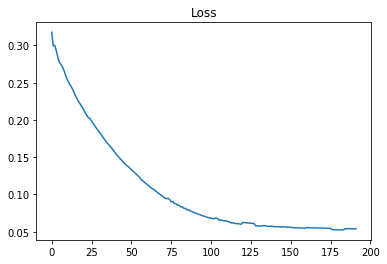

In [9]:
%matplotlib inline

plt.plot(loss)
plt.title("Loss")
plt.show()

In [10]:
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap

def plot_error_colormapped_axis_position(target, predicted, axis):
    fig = plt.figure(figsize=(18, 2), dpi= 80, facecolor='w', edgecolor='k')
    
    fig.gca().plot(target[:,axis], color='black', alpha=0.3)
    cmap = LinearSegmentedColormap.from_list("", [(0, 0.8, 0), (0.8, 0, 0)])
    time = np.linspace(0, osulearn.dataset.BATCH_LENGTH, osulearn.dataset.BATCH_LENGTH)
    pos = predicted[:,axis]
    diff = np.absolute(target[:,axis] - predicted[:,axis])
    points = np.array([time, pos]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-2],points[1:-1], points[2:]], axis=1)
    
    norm = plt.Normalize(0, 0.1)
    
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(diff)
    fig.gca().add_collection(lc)
    fig.gca().autoscale()
    fig.show()

def plot_info(target, predicted):
    %matplotlib inline
    
    plot_error_colormapped_axis_position(target, predicted, 0)
    plt.title("X")
    plt.show()
    
    plot_error_colormapped_axis_position(target, predicted, 1)
    plt.title("Y")
    plt.show()

Batch 0


c:\users\guigb\anaconda3\envs\tf_gpu\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


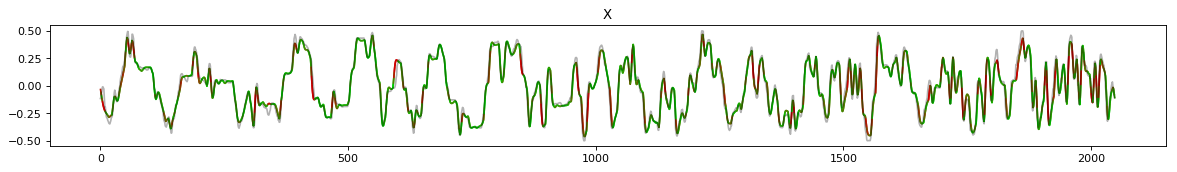

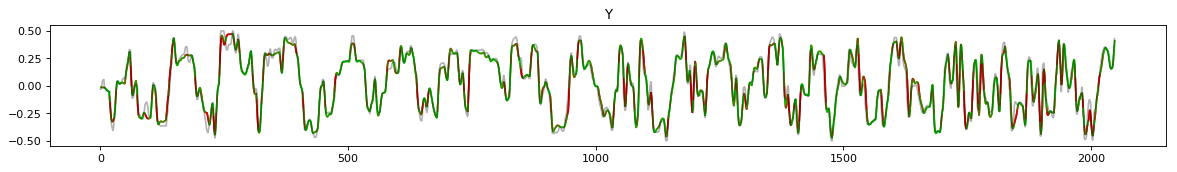




Batch 1


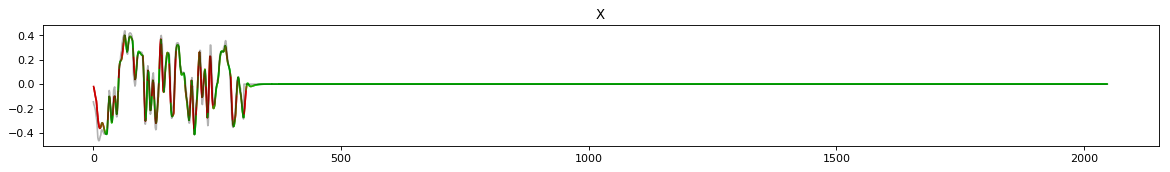

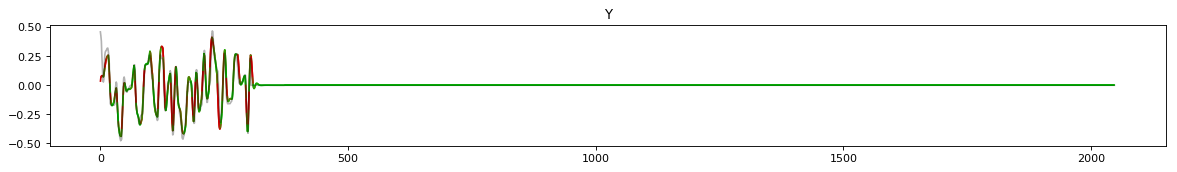




Batch 2


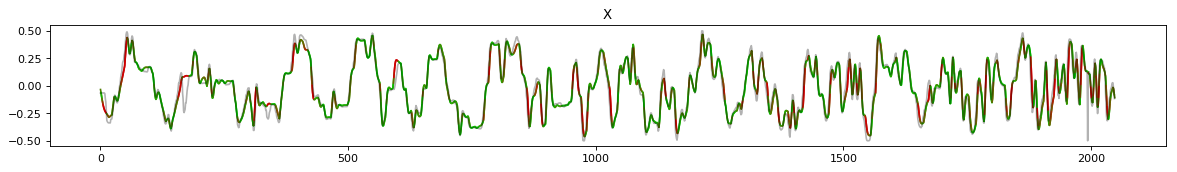

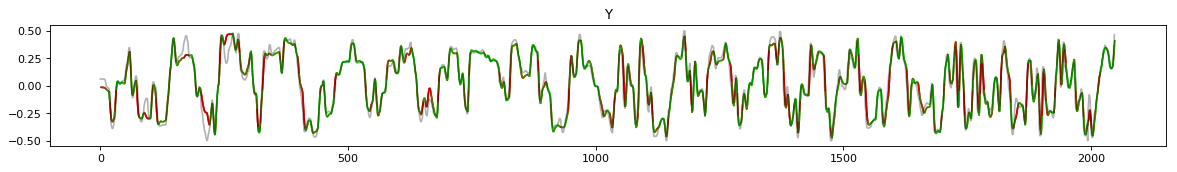




Batch 3


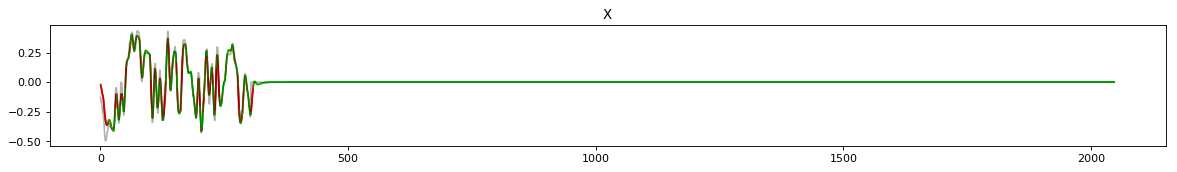

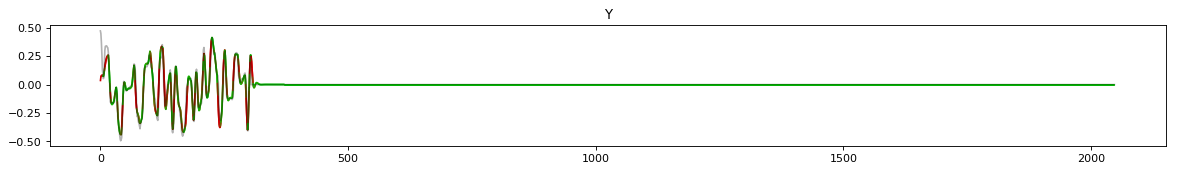




Batch 4


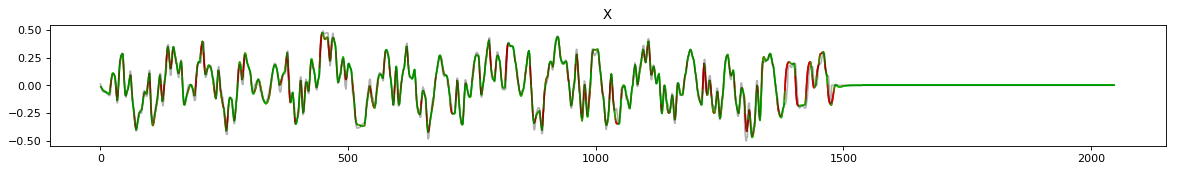

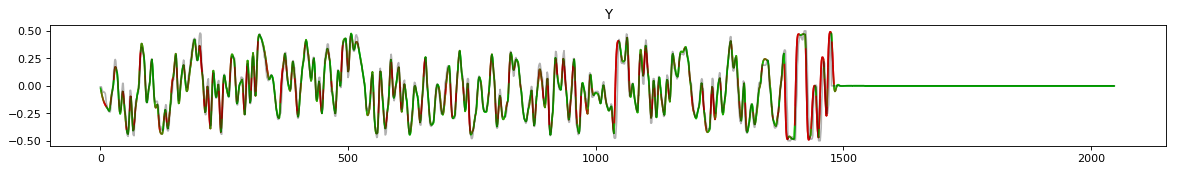




Batch 5


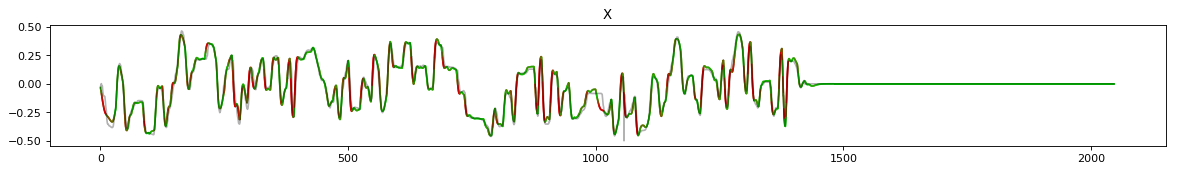

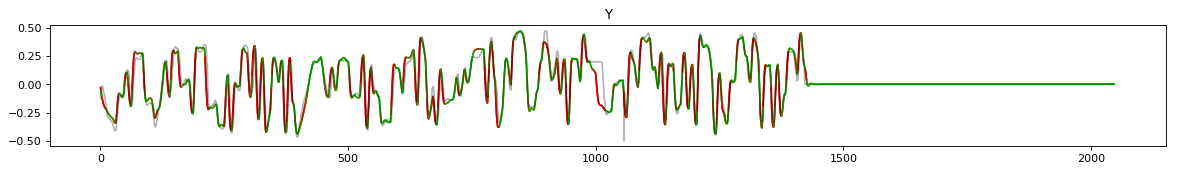




Batch 6


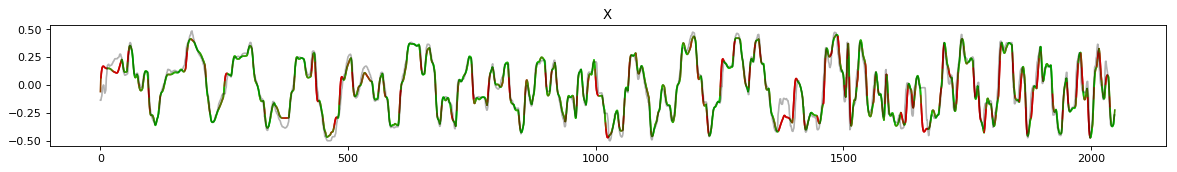

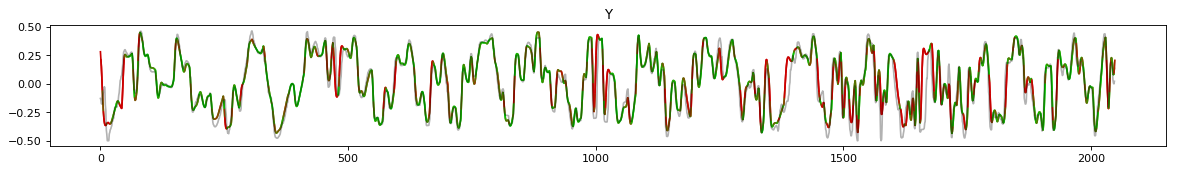




Batch 7


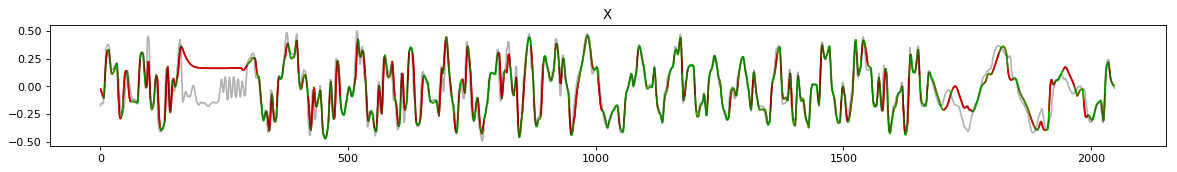

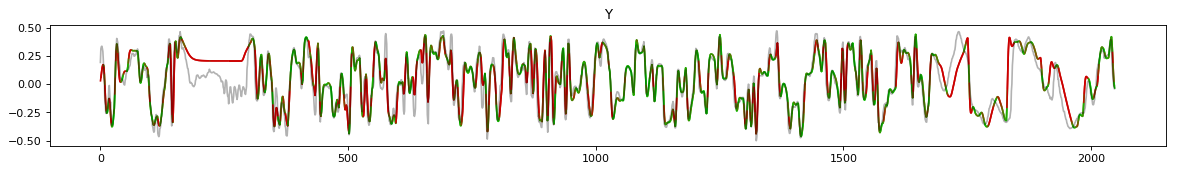




Batch 8


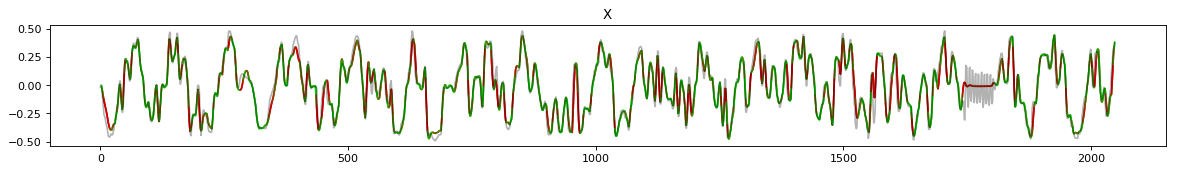

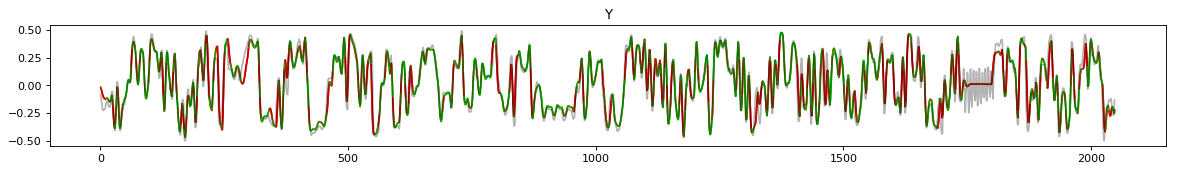




Batch 9


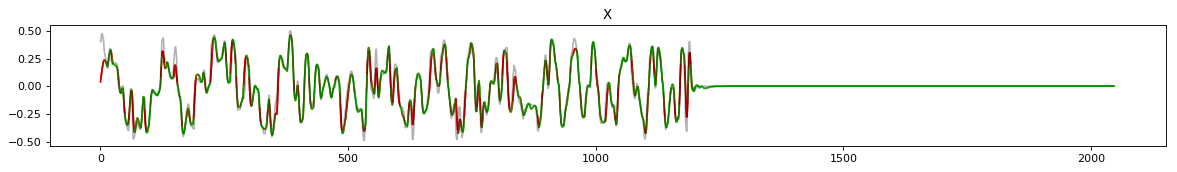

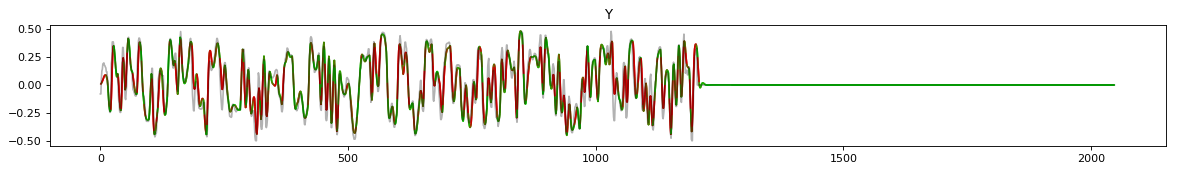

In [11]:
predicted_pos = model.predict(X)
    
for i in range(10):
    print("Batch", i)
    plot_info(y[i], predicted_pos[i])
    print()
    print()
    print()

You might have noticed that even when the loss is as low as 0.06 the predictions do not match the target data quite so well. That is not a huge problem though, since we do not really want the IA to match exactly our moves on every replay.

The movements between a circle and the next one on osu! are mostly unpredictable, and the best we can do is approximate them. The really important part is that the IA can aim for the circles and move the cursor over them in time.

Implementing a GAN would solve most of these problems, as it would not try to generate replays exactly like the target data, but replays that "look similar" to them. That will be explored in the future.

Finally, let's validate our model and preview a replay it generates for a map it has never seen before:

C:/Users/guigb/AppData/Local/osu!\Songs\864947 MY FIRST STORY - Itazura Fiction\MY FIRST STORY - Itazura Fiction (Akitoshi) [Chaos].osu


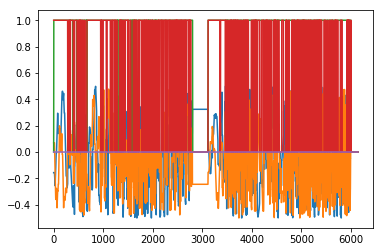

Done.


In [12]:
BEATMAPS_FOLDER = os.path.join(OSU_FOLDER, 'Songs')
BEATMAP = glob.glob(BEATMAPS_FOLDER + "\\**\\*Itazura Fiction*Akitoshi*Chaos*.osu")[0]
print(BEATMAP)

beatmap = osu.rulesets.beatmap.load(BEATMAP)
data = osulearn.dataset.input_data(beatmap)
data = np.reshape(data.values, (-1, osulearn.dataset.BATCH_LENGTH, len(osulearn.dataset.INPUT_FEATURES)))

plt.plot(np.concatenate(data))
plt.show()

predicted = model.predict(data)

np.save('osu/replay.npy', np.concatenate(predicted))
print("Done.")

To preview the generated replay, run this on OsuLearn root directory:
```
python -m osu.preview
```

This script needs [`pygame`](https://www.pygame.org/news) and [`mutagen`](https://mutagen.readthedocs.io/en/latest/) to run.

## Known Issues

Ok, so we've seen the AI can do quite well even on maps it has never been trained to play before, but of course there's some things we can notice it can't do at all:

- Spinners: It simply ignores them, haha!
- Break time "random" movements: during break times the best it can do is just hold the cursor on the center of the screen.

What I would guess is happening is that those two actions usually do not have an easily distinguishable pattern to them (spinners are usually "spinned", I know, but it's not as precise as aiming or following sliders, since spin direction, speed, radius, etc. varies a lot in a way that is not really predictable). Since we're using a kind of regression technique, it makes sense the model couldn't figure those out.

The solution?

Use a GAN!!! (╯°□°)╯︵ ┻━┻